## Test01_2 MNE

เปลี่ยนการเขียน csp และก่อนเข้า csp ลองแยก split

- Preprocessing
- Feature Extraction
- Classification

link to dataset: https://ieee-dataport.org/documents/upper-limb-rehabilitation-motor-imagery-eeg-signals - 1398.18 Baht

- EEG Placement 10-20 electrode system

- Notch filter 50 hz applied

- 8th order chebyshev bandpass filter 0.01 hz - 200hz appiled

- Sampling rate 500 Hz

**Planning: Use only 1 subjects for testing code.**

1. Read all .set files, find only S1R1 - S1R10
2. merge the files in to 1 set
3. Preprocessing (Fliter + Baseline correction + Epoching)
4. Epoching only Flexion and Extension 

In [1]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import re
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
import onnxruntime
import torch
import seaborn as sns
import pandas as pd
from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from IPython.display import display

#### Step 1: READ Dataset 

- read only S1R1 - S1R10
- rename label from 'elbow flexion' to 'S1R1_elbow flexion' for easy to concat

In [ ]:
folder_path = 'G:\\KMUTT\\Y3_Term2\\Studio_OpenTopic\\StudioV_opentopics\\Dataset_used'
subjects = [1, 2, 3, 4, 5, 6]

# ครบทุกคลาส 6 แบบ
label_map = {
    'forearm supination': 0,
    'elbow extension': 1,
    'forearm pronation': 2,
    'shoulder adduction': 3,
    'shoulder abduction': 4,
    'elbow flexion': 5
}

# Helper เรียงตาม Run
def extract_run_num(name):
    match = re.search(r'R(\d+)', name)
    return int(match.group(1)) if match else 0

# เตรียมเก็บข้อมูล
all_X = []
all_y = []

# Loop ทุก subject และ run
for subject in subjects:
    for file_name in sorted(os.listdir(folder_path), key=extract_run_num):
        if file_name.startswith(f"S{subject}R") and file_name.endswith(".set"):
            path = os.path.join(folder_path, file_name)
            print(f"📂 Reading {file_name}...")

            try:
                epochs = mne.io.read_epochs_eeglab(path, verbose='ERROR')
                id_to_name = {v: k for k, v in epochs.event_id.items()}

                for i, eid in enumerate(epochs.events[:, 2]):
                    full_name = id_to_name[eid]
                    action = full_name.split('_')[-1]
                    if action in label_map:
                        signal = epochs.get_data()[i]
                        all_X.append(signal)
                        all_y.append(label_map[action])

            except Exception as e:
                print(f"❌ Failed to load {file_name}: {e}")

# รวมทั้งหมดเป็น array
X_all = np.stack(all_X, axis=0)
y_all = np.array(all_y)

# แสดงผล
print("✅ รวมข้อมูลทุก subject และทุกคลาสเสร็จแล้ว:")
print("🧠 Shape of EEG:", X_all.shape)
print("🏷️ Shape of labels:", y_all.shape)
print("🔢 Label distribution (0–5):", np.bincount(y_all))


Extracting parameters from G:\KMUTT\Y3_Term2\Studio_OpenTopic\StudioV_opentopics\Dataset_used\S1R1.set...
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from G:\KMUTT\Y3_Term2\Studio_OpenTopic\StudioV_opentopics\Dataset_used\S1R2.set...
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from G:\KMUTT\Y3_Term2\Studio_OpenTopic\StudioV_opentopics\Dataset_used\S1R3.set...
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from G:\KMUTT\Y3_Term2\Studio_OpenTopic\StudioV_opentopics\Dataset_used\S1R4.set...
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from G:\KMUTT\Y3_Term2\Studio_OpenTopic\StudioV_opentopics\Dataset_used\S1R5.set...
Not setting me

In [3]:
S1_EpochList

[<EpochsEEGLAB | 180 events (all good), -1 – 1.998 s (baseline off), ~33.0 MiB, data loaded,
  'S1R1_forearm supination': 30
  'S1R1_elbow extension': 30
  'S1R1_forearm pronation': 30
  'S1R1_shoulder adduction': 30
  'S1R1_shoulder abduction': 30
  'S1R1_elbow flexion': 30>,
 <EpochsEEGLAB | 180 events (all good), -1 – 1.998 s (baseline off), ~33.0 MiB, data loaded,
  'S1R2_forearm pronation': 30
  'S1R2_elbow extension': 30
  'S1R2_elbow flexion': 30
  'S1R2_forearm supination': 30
  'S1R2_shoulder abduction': 30
  'S1R2_shoulder adduction': 30>,
 <EpochsEEGLAB | 180 events (all good), -1 – 1.998 s (baseline off), ~33.0 MiB, data loaded,
  'S1R3_elbow extension': 30
  'S1R3_elbow flexion': 30
  'S1R3_shoulder adduction': 30
  'S1R3_shoulder abduction': 30
  'S1R3_forearm pronation': 30
  'S1R3_forearm supination': 30>,
 <EpochsEEGLAB | 180 events (all good), -1 – 1.998 s (baseline off), ~33.0 MiB, data loaded,
  'S1R4_elbow flexion': 30
  'S1R4_elbow extension': 30
  'S1R4_shoulder 

##### Rename labels after concat

In [4]:
# Mapping: 'S1R1_elbow flexion' → 'elbow flexion'
label_map = {}
for K in combined_epochs.event_id:
    new_label = K.split('_', 1)[-1]
    label_map[K] = new_label

# สร้าง event_id 
new_event_id = {}
new_events = []

for I in combined_epochs.events:
    old_event_id = I[2]
    K = [k for k, v in combined_epochs.event_id.items() if v == old_event_id][0]
    new_label = label_map[K]

    if new_label not in new_event_id:
        new_event_id[new_label] = len(new_event_id) + 1

    new_events.append([I[0], I[1], new_event_id[new_label]])

# อัปเดต combined_epochs
combined_epochs.events = np.array(new_events)
combined_epochs.event_id = new_event_id


##### Test Combined data

In [5]:
# combined_epochs.equalize_event_counts
combined_epochs.event_id
# combined_epochs

{'forearm supination': 1,
 'elbow extension': 2,
 'forearm pronation': 3,
 'shoulder adduction': 4,
 'shoulder abduction': 5,
 'elbow flexion': 6}

Event counts: {1: 300, 2: 300, 3: 300, 4: 300, 5: 300, 6: 300}
Using matplotlib as 2D backend.


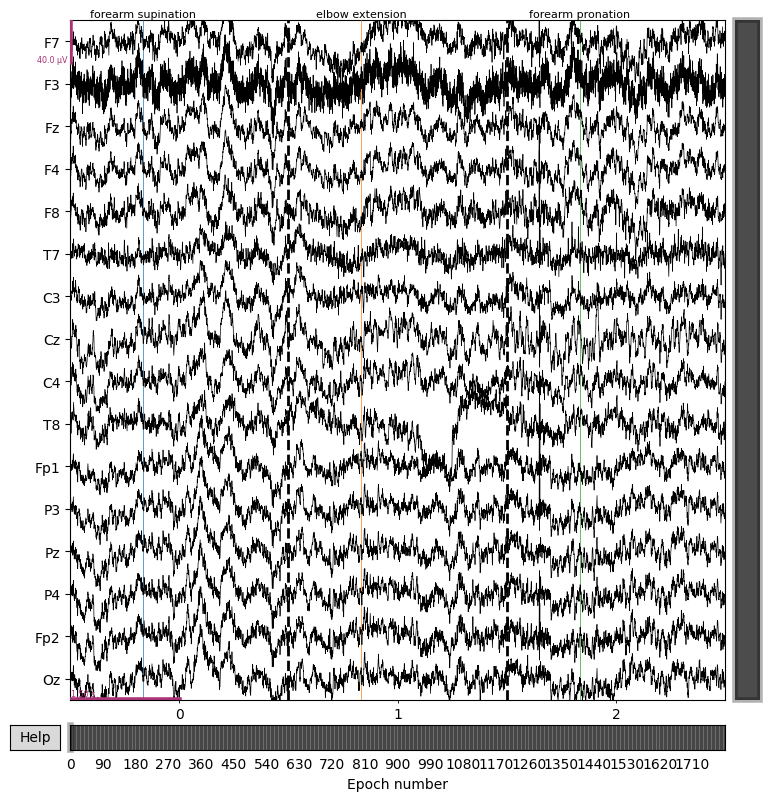

Epoch 0: forearm supination
Epoch 1: elbow extension
Epoch 2: forearm pronation
Epoch 3: shoulder adduction
Epoch 4: shoulder adduction
Epoch 5: shoulder abduction
Epoch 6: forearm pronation
Epoch 7: shoulder adduction
Epoch 8: forearm pronation
Epoch 9: elbow extension
Epoch 10: forearm pronation
Epoch 11: elbow extension
Epoch 12: forearm supination
Epoch 13: elbow extension
Epoch 14: elbow extension
Epoch 15: forearm supination
Epoch 16: forearm pronation
Epoch 17: shoulder adduction
Epoch 18: shoulder abduction
Epoch 19: forearm supination
Epoch 20: forearm pronation
Epoch 21: shoulder adduction
Epoch 22: forearm supination
Epoch 23: shoulder abduction
Epoch 24: elbow extension
Epoch 25: forearm pronation
Epoch 26: forearm supination
Epoch 27: elbow flexion
Epoch 28: shoulder abduction
Epoch 29: forearm supination
Epoch 30: forearm supination
Epoch 31: elbow flexion
Epoch 32: elbow extension
Epoch 33: shoulder abduction
Epoch 34: elbow extension
Epoch 35: shoulder adduction
Epoch 3

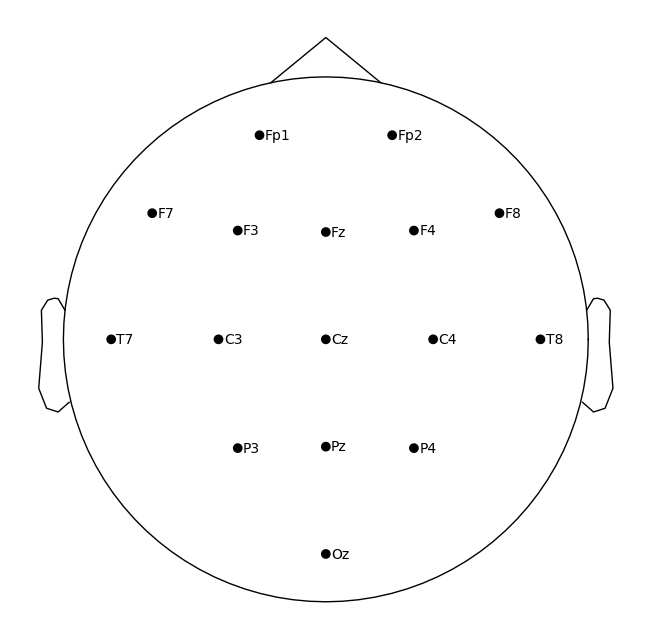

In [6]:
# Check event occurs
event_ids = combined_epochs.events[:, 2] #column 3

unique, counts = np.unique(event_ids, return_counts=True)

event_counts = dict(zip(unique, counts))
print("Event counts:", event_counts)

#Check sensor location
# Pic = combined_epochs.plot_sensors(show_names=True, sphere =0.1) 

# Plot epochs and show event names
fig = combined_epochs.plot(n_epochs=3,events=True, event_id = True)


# Plot each epoch name
for i in range(len(combined_epochs)):
    event_id = combined_epochs.events[i, 2]
    label = [k for k, v in combined_epochs.event_id.items() if v == event_id]
    print(f"Epoch {i}: {label[0] if label else 'Unknown'}")

Pic = combined_epochs.plot_sensors(show_names=True, sphere =0.125) #ยิ่งเพิ่มยิ่งลดขนาด

### Step 2: Preprocessing 

#### Bandpass filter